In [1]:
import numpy as np
from src.cost import LogCost
from src.cpop import CPOP
import matplotlib.pyplot as plt

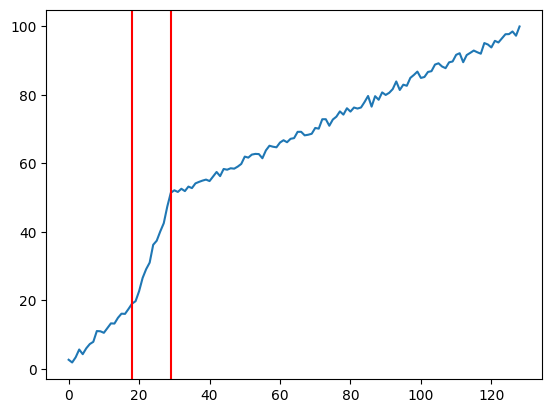

In [2]:
y = np.concatenate([np.arange(1, 20), np.arange(20, 50, 3), np.arange(50, 100, 0.5)])
y += np.random.randn(len(y))
h = LogCost(1)
sigma = 1
beta = 200

detector = CPOP(y, sigma, beta, h)
output = detector.run()
output = [x-1 for x in output] # On doit supprimer un indice
plt.plot(y)
for idx in output[1:-1]: # On ne prends pas en compte le premier change points (0 par convention)
    plt.axvline(idx, c="r")

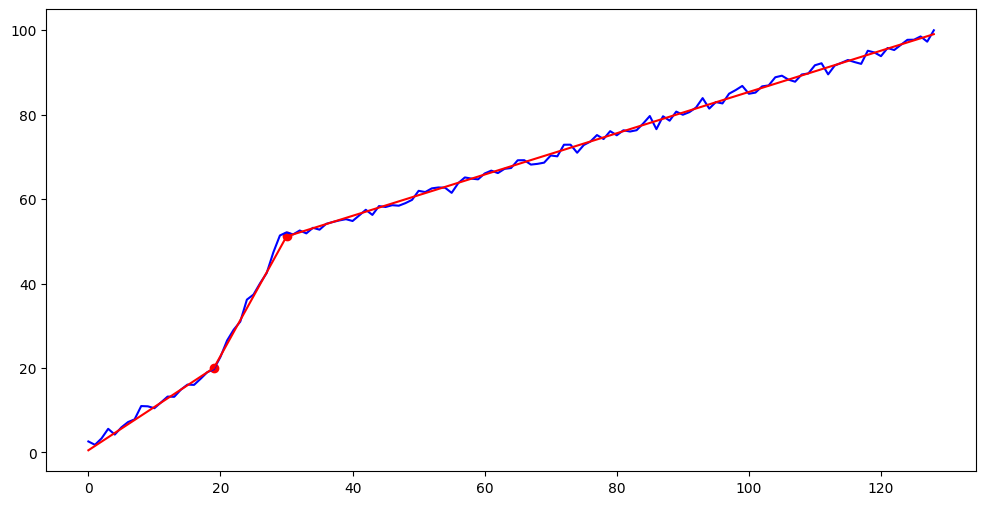

In [3]:
detector.compute_approx_and_plot()

In [4]:
import pandas as pd

df = pd.read_csv("../data/gdp.csv", skiprows=4)

In [5]:
df = df[df["Country Name"]=="Argentina"]

columns_years = [col for col in df.columns if col.isdigit()]  # Filtrer les années
serie_temporelle = df.loc[:, columns_years]  # Extraire les données pour la première ligne

serie = serie_temporelle.reset_index(drop=True).T
y = serie[0].to_numpy()

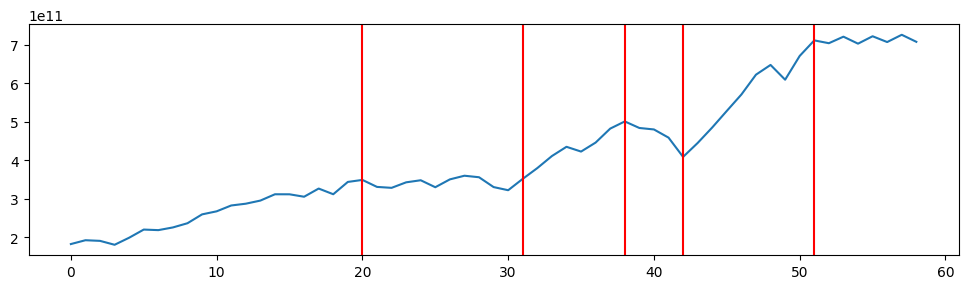

In [7]:
h = LogCost(1)
sigma = serie[0].diff().std()
beta = 10

detector = CPOP(y, sigma, beta, h)
output = detector.run()
out = output
plt.figure(figsize=(12,3))
plt.plot(y)
for idx in out[1:-1]: # On ne prends pas en compte le premier change points (0 par convention)
    plt.axvline(idx, c="r")

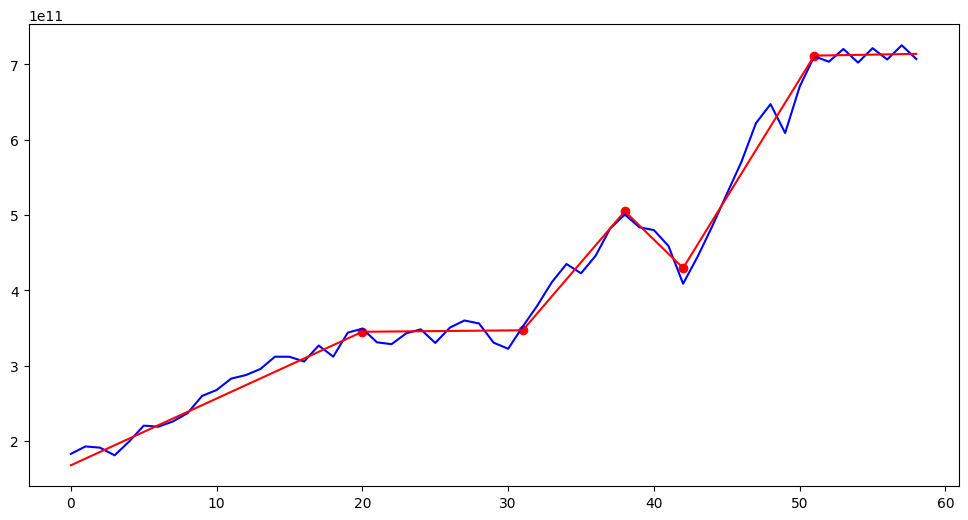

In [8]:
detector.compute_approx_and_plot()

In [9]:
from src.pelt import PELT
from src.cost import cost_L2

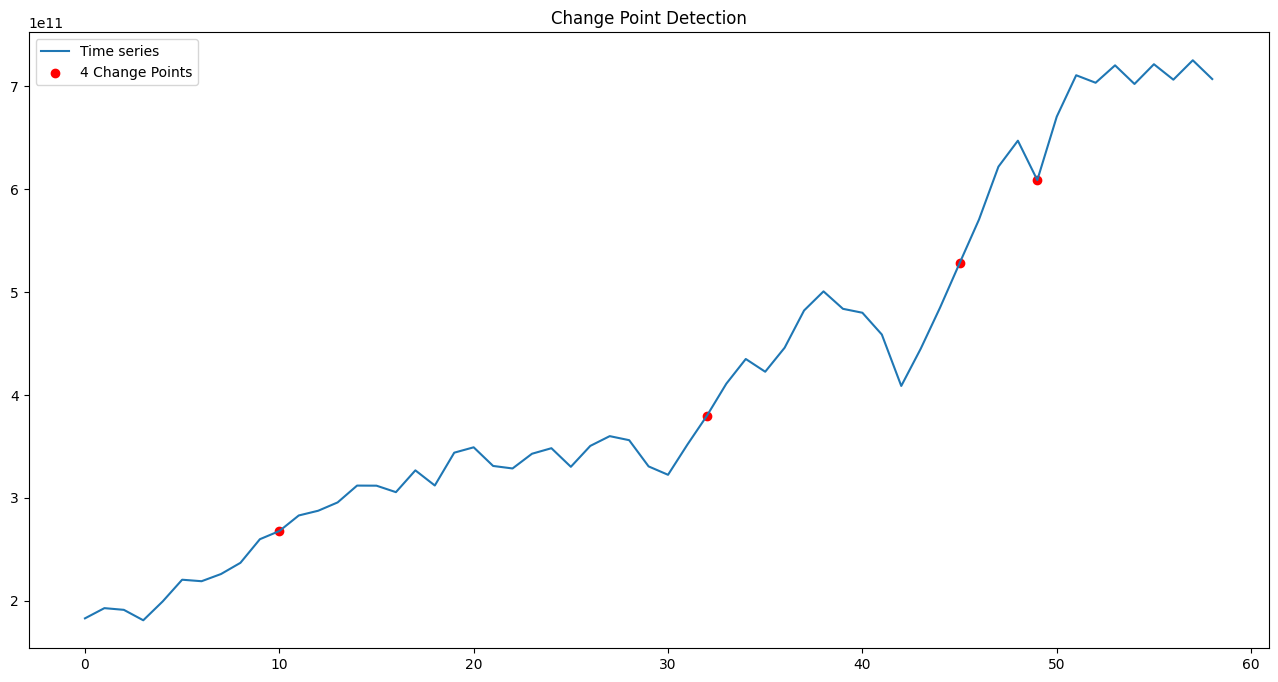

In [13]:
pelt = PELT(y, cost_L2, 8)
pelt.run()
pelt.show_changepoints(4)